In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import scipy.signal
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

Text(0.5, 0, 'Episodes')

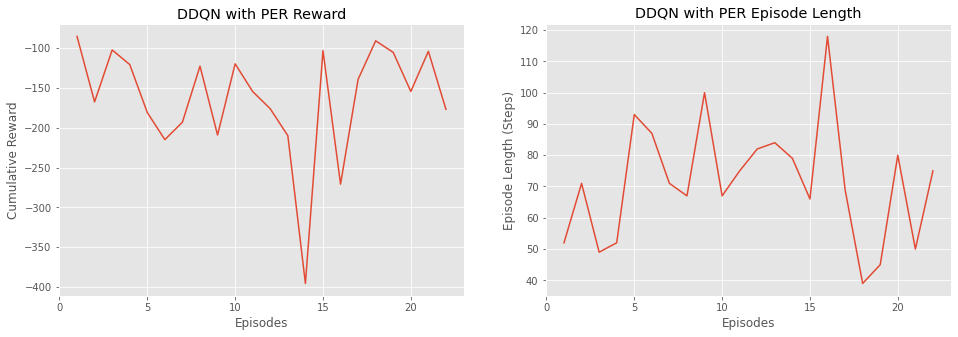

In [61]:
plt.style.use('ggplot')
df = pd.read_csv("WEEK 4 - DQN/logs_dqn.txt", header=None)
fig,ax = plt.subplots(figsize=(16,5),ncols=2,nrows=1)


ax[0].plot( df.iloc[:,0].values, df.iloc[:,2].values )
ax[0].set_title('DDQN with PER Reward')
ax[0].set_ylabel("Cumulative Reward")
ax[0].set_xlabel("Episodes")


ax[1].plot( df.iloc[:,0].values, df.iloc[:,3].values )
ax[1].set_title('DDQN with PER Episode Length')
ax[1].set_ylabel("Episode Length (Steps)")
ax[1].set_xlabel("Episodes")

In [42]:
tf.config.list_physical_devices("GPU")

[]

In [82]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

/opt/anaconda3/envs/c557/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [83]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [84]:
num_actions = 3
observation_dimensions = (128, 128, 3)

In [6]:
def Model():
    inp = keras.layers.Input( shape=observation_dimensions )
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', 
                            padding='same', activation="relu")(inp)
#     x = keras.layers.AveragePooling2D( (2,2) )(x)
#     x = keras.layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', 
#                             padding='same', activation="relu")(x)
    x = keras.layers.AveragePooling2D( (2,2) )(x)
    x = keras.layers.Conv2D(filters=8, kernel_size=(3,3), kernel_initializer='he_normal', 
                            padding='same', activation="relu")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(num_actions, activation="softmax")(x)
    return keras.models.Model( inp, x )

In [65]:
model = Model()
model.compile( optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256

In [8]:
import os

In [63]:
data = pd.read_csv("action_took.csv").drop_duplicates()
print(data.shape)
data = data[ data.iloc[:,0] != "0" ]
data.shape

(4050, 2)


(4050, 2)

In [66]:
images = []
for img in data.iloc[:,0]:
    images.append(cv2.imread(img).reshape((-1,128,128,3)) )
images = np.concatenate(images, axis=0)
images.shape

(4050, 128, 128, 3)

In [67]:
data.iloc[:,1].value_counts()

-1    1955
 1    1285
 0     810
Name: 1, dtype: int64

In [68]:
labels = (data.iloc[:,1]+1).values

In [69]:
target = np.zeros( (len(images), 3) )
target.shape

(4050, 3)

In [70]:
for i in range(len(labels)):
    target[i][ labels[i] ] = 1

In [71]:
target.sum(axis=0)

array([1955.,  810., 1285.])

In [72]:
model.fit( images[:2050]/255, target[:2050], validation_split=0.2, batch_size=128, epochs=5 )

Epoch 1/5
13/13 [==============================] - 7s 501ms/step - loss: 0.7448 - accuracy: 0.6579 - val_loss: 0.3142 - val_accuracy: 0.9293
Epoch 2/5
13/13 [==============================] - 6s 485ms/step - loss: 0.5836 - accuracy: 0.7396 - val_loss: 0.3295 - val_accuracy: 0.9073
Epoch 3/5
13/13 [==============================] - 6s 491ms/step - loss: 0.5542 - accuracy: 0.7512 - val_loss: 0.2357 - val_accuracy: 0.9244
Epoch 4/5
 5/13 [==========>...................] - ETA: 3s - loss: 0.5415 - accuracy: 0.7484

KeyboardInterrupt: 

In [79]:
model.save("classifier.h5")

In [18]:
model = keras.models.load_model("classifier.h5")

In [73]:
import gym
import gym_carla
import carla

In [74]:
#WetCloudyNoon, WetSunset, HardRainNoon

In [75]:
params = {
    'number_of_vehicles': 0,
    'number_of_walkers': 0,
    'display_size': 250,  # screen size of bird-eye render
    'display_height' : 512,
    'display_main': True,
    'weather': "WetSunset",
    'max_past_step': 1,  # the number of past steps to draw
    'dt': 0.1,  # time interval between two frames
    'discrete': False,  # whether to use discrete control space
    'discrete_acc': [1.0, 0.0, 1.0],  # discrete value of accelerations
    'discrete_steer': [-1, 0, 1],  # discrete value of steering angles
    'continuous_accel_range': [-3.0, 3.0],  # continuous acceleration range
    'continuous_steer_range': [-0.2, 0.2],  # continuous steering angle range
    'ego_vehicle_filter': 'vehicle.tesla.model3',  # filter for defining ego vehicle
    'address': "192.168.1.173", #'localhost',
    'port': 8080, #2000 # connection port
    'town': 'Town02', # which town to simulate
    'task_mode': 'random',  # mode of the task, [random, roundabout (only for Town03)]
    'max_time_episode': 5000,  # maximum timesteps per episode
    'max_waypt': 12,  # maximum number of waypoints
    'obs_range': 32,  # observation range (meter)
    'lidar_bin': 0.125,  # bin size of lidar sensor (meter)
    'd_behind': 12,  # distance behind the ego vehicle (meter)
    'out_lane_thres': 5.0,  # threshold for out of lane
    'desired_speed': 8,  # desired speed (m/s)
    'max_ego_spawn_times': 200,  # maximum times to spawn ego vehicle
    'display_route': True,  # whether to render the desired route
    'pixor_size': 64,  # size of the pixor labels
    'pixor': False,  # whether to output PIXOR observation
  }

In [76]:
def read_transform(img):
    return img[76:204,76:204,:]/255
env = gym.make('carla-v0', params=params)

connecting to Carla server...
Carla server connected!


In [78]:
observation =  env.reset()
for _ in range(20): observation, _, _, _ = env.step([1,0])
done = False
while not done:
    #action = np.random.choice( [-1,0,1], p=model.predict( read_transform(observation['birdeye']).reshape( (1, 128,128,3) ))[0])
    action = np.argmax(model.predict( read_transform(observation['birdeye']).reshape( (1, 128,128,3) ))[0])-1
    observation, _, done, _ = env.step( [1,action] ) 

KeyboardInterrupt: 